In [1]:
#! pip install pyadi-iio
#! pip install matplotlib
#! pip install scikit-dsp-comm
#! pip install scikit-commpy

import numpy as np
#import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
# Función para graficar señales
def plot_signal(_title, _xlabel, _ylabel, _time, *signals, _ticks=False):
    _fig, _ax = plt.subplots(figsize=(15, 4))
    _fig.patch.set_facecolor('black')
    plt.title(_title, fontdict={'color':'white', 'weight':'bold'})
    _ax.set_facecolor('black')
    for i in range(len(signals)):
        plt.plot(_time, signals[i])
    plt.xlabel(_xlabel, fontdict={'color':'white', 'weight':'bold'})
    plt.ylabel(_ylabel, fontdict={'color':'white', 'weight':'bold'})
    if not _ticks:
        plt.xticks([_time[0], _time[-1]], visible=True, rotation="horizontal")
    _ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
    plt.grid()
    plt.show()

# Chirp spread spectrum modulation (CSS):

### ¿Qué es un chirp?

Como el nombre lo indica la modulación CSS consiste en la transmisión de símbolos en forma de **chirps** defasados una frecuencia $\theta$ para cada símbolo. A estas alturas nos podemos preguntar entonces ¿Qué es un chirp?

Un chirp o *sweep signal* es una señal sinusoidal que inicia con una frecuencia inicial $f_i$ la cual aumenta o desciende linealmente en el tiempo hasta llegar a una frecuencia final $f_f$. Si la frecuencia incremente hablamos de un **up-chirp**, en cámbio si la misma decrece se trata de un **down-chirp**.

### Hipótesis

Antes de definir la modulación de nuestro sistema de comunicaciones primero corresponde definir la fuente. La misma se definirá como $H$ la cual tendrá $2^{SF}$ hipótesis equiprobables, donde SF se llama *"Spreading factor"* y suele tomar valores entre 7 y 12.

$$H \in \{0, 1, ..., (2^{SF} - 1)\}$$

A nuestra hipótesis $i$ la podemos representar como $s(nT_c)$ donde $n$ es un entero positivo y $T_c$ es el periodo entre símbolos transmitidos, de modo que cada $s$ estará directamente asociado con un valor de $n$ y de $i$, indicando $i$ la forma del símbolo y $n$ el periodo de tiempo en que se transmite. Por último cabe aclarar que el valor de $T_c$ no es arbitrario, sino que corresponde a la fórmula $T_c = (2^{SF})T_s$ donde $T_s$ es el periodo de muestréo, que cumpliendo el criterio de Nyquist sabemos que será $T_s \leq 1/B$. Así, cada hipótesis $i$ se transmite durante un tiempo que depende directamente del ancho de banda y el *Spreading Factor*, de modo que incrementar el primero reduce el tiempo entre símbolos, acelerando la comunicación a cambio de acaparar un mayor rango en frecuencia, mientras que el $SF$ será directamente proporcional al periodo entre símbolos, siendo así este periodo (y por ende la velocidad de transmisión) el costo de transmitir un mayor número de bits por palabra, a menos que se compense nuevamente acaparando un mayor ancho de banda.

### Modulación

Ahora sí, nos encontramos en posición de estudiar nuestro formador de ondas o modulador. Matemáticamente, esta se define como:

$$c(nT_c + kT_s) = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi[|s(nT_c)+k|_{mod 2^{SF}}]\frac{kT_sBw}{2^{SF}}}, k\in\left\{ 0, 2^SF-1 \right\}$$

Donde la expresión $c(nT_c + kT_s)$ hace referencia al símbolo transmitido en el periodo $nT_c$ y las muestras del mismo que se toman cada $kT_s$.

La exponencial compleja es una función periódica, y podemos ver que su frecuencia dependerá de $s(nT_c)+k$. Dado un símbolo cualquiera $s(nT_c)$ será constante, por lo que este valor determinará únicamente la frecuencia inicial, luego la variable $k$ que representa los instantes del tiempo donde se toma una muestra, hará que esta frecuencia incremente hasta $S(nT_s)+2^{SF}$. Esto en un principio implicaría que por cada símbolo extra nuestro ancho de banda se ampliaría, pero revisando la fórmula nuevamente podemos notar la presencia de un operador módulo $|s(nT_s)+k|_{mod 2^{SF}}$ donde el subíndice $2^{SF}$ implica que ese es el valor máximo para la adición mencionada, cuando el contenido de este módulo alcance el máximo, volverá a 0, por lo que el operador es equivalente a tomar el resto de la división natural entre el argumento $s(nT_s)+k$ y el índice $2^{SF}$. Queda claro entonces que el valor de este módulo varía entre 0 y $ 2^{SF} - 1 $.

De la definición de la forma de onda también podemos notar que existe una relación lineal entre el dominio de la frecuencia y de los símbolos, con lo que un símbolo $s$ se traduce a frecuencia como $f_s = s \frac{Bw}{2^{SF}}$, donde esta frecuencia está presente en nuestra exponencial, de modo que introduciéndola al módulo con la propiedad:

$$a|x|_{mod b} = |ax|_{mod ab}$$

Obtenemos:

$$c(nT_c + kT_s) = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi[|(s(nT_c)+k)Bw/2^{SF}|_{mod Bw}]kT_s}, k\in\left\{ 0, 2^SF-1 \right\}$$

$$c(nT_c + kT_s) = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi[|f_s+(k\frac{Bw}{2^{SF}})|_{mod Bw}]kT_s}, k\in\left\{ 0, 2^SF-1 \right\}$$

Observamos que si no limitamos los valores de "n", la fórmula anterior es periódica, de modo que el símbolo "S" se repite cada $T_c$. . Por otra parte, en este periodo el símbolo 0 será el único que no superará el límite del módulo, obteniendo: 

$$c(nT_c + kT_s)_0 = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi (k\frac{Bw}{2^{SF}}) kT_s}, k\in\left\{ 0, 2^SF-1 \right\}$$

Luego aprovechando la periodicidad de esta fórmula podemos redefinir los demás símbolos como:

$$c(nT_c + kT_s)_s = c(nT_c + (k+s)T_s)_0 = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi ((k+s)\frac{Bw}{2^{SF}}) (k+s)T_s}, k\in\left\{ 0, 2^SF-1 \right\}$$

Nótese que esta definición inicia en un instante de tiempo $k + s$ que debe ser leído como el instánte $t=0$. Si ahora enfocamos la definición a un único valor de n, es decir tomamos un único chirp, para así estudiar el símbolo, podemos definir el símbolo como:

$$c(kT_s)_s = \left\{\begin{matrix}
\frac{1}{\sqrt{2^{SF}}}e^{j2\pi ((k+s)\frac{Bw}{2^{SF}}) (k+s)T_s}, (k+s) < 2^{SF} \\
\frac{1}{\sqrt{2^{SF}}}e^{j2\pi ((k+s-2^{SF})\frac{Bw}{2^{SF}}) (k+s-2^{SF})T_s}, (k+s)\geq 2^{SF}
\end{matrix}\right.$$

$$c(kT_s)_s = \frac{1}{\sqrt{2^{SF}}}e^{j2\pi (q\frac{Bw}{2^{SF}}) qT_s}, q=|s+k|_{2^{SF} } \wedge k\in\left\{ 0, 2^SF-1 \right\}$$

Desligándonos de esta manéra del módulo. A continuación se muestra un código en python para generar señales de este tipo.

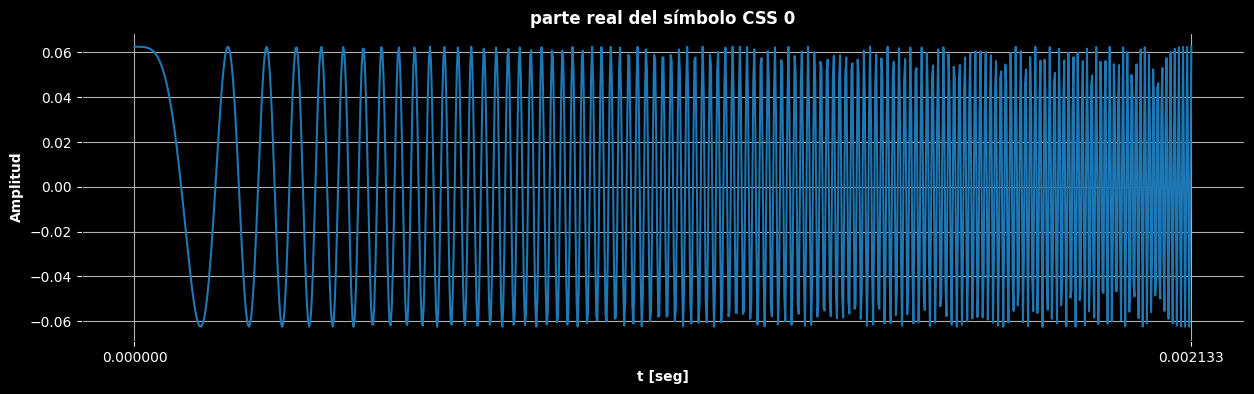

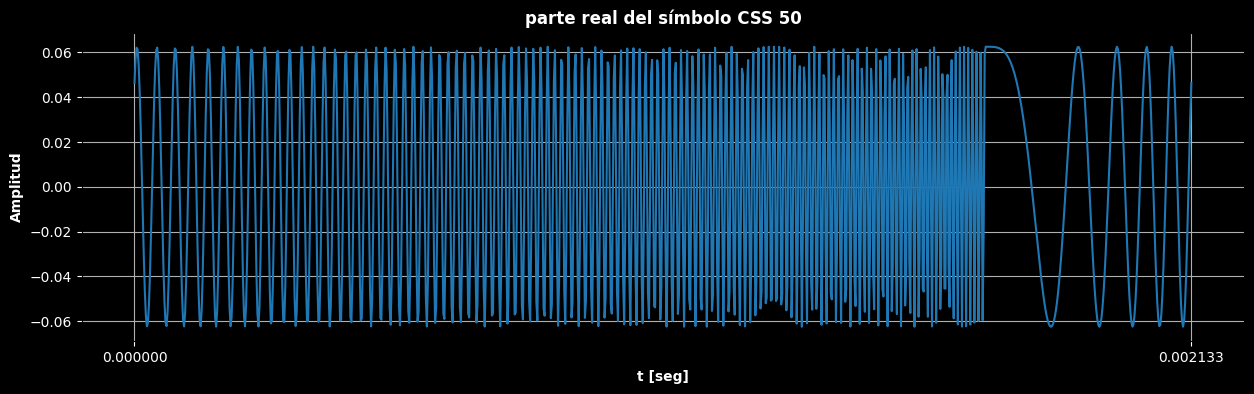

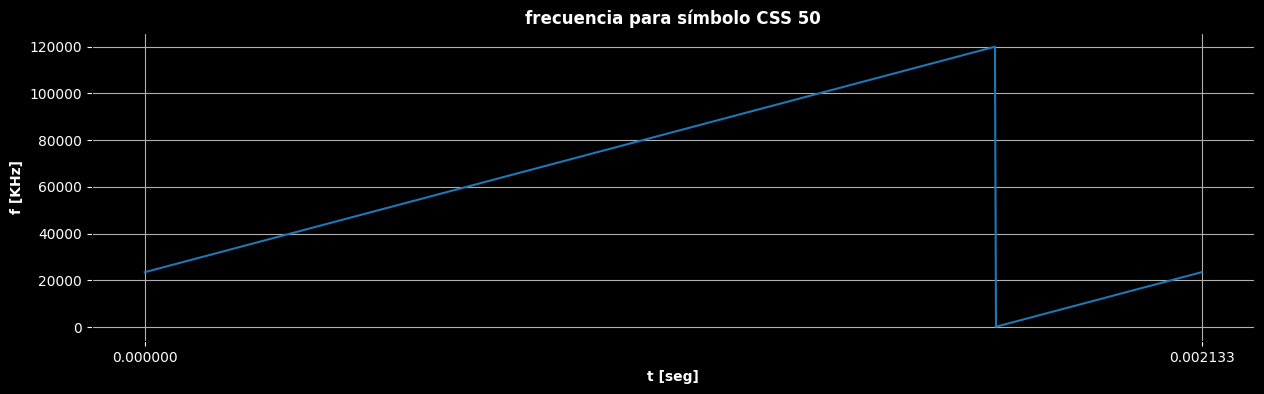

In [20]:
# Parámetros
SF = 8                                  # Spreading Factor
Bw = 120e3                              # Ancho de banda [KHz]
N = 2**SF                               # Símbolos posibles
Tc = N/Bw                               # Periodo entre símbolos [ms]
Ts = 1/Bw                               # Periodo de muestreo mínimo [ms]
delta = 1/4                             # Factor de sobre-muestreo (0:1] [1/muestras]
samples_per_symbol = int(N/delta)       # Muestras por símbolo [muestras]
samples_per_second = int(1/(delta*Ts))  # Muestras por segundo [muestras/ms]
symbol = 50                            # Símbolo a transmitir

def set_sf(_sf):
    global SF, N, Tc, samples_per_symbol
    SF = _sf
    N = 2**SF
    Tc = N/Bw
    samples_per_symbol = int(N/delta)

def set_bandwidth(_bw):
    global Bw, Tc, Ts, samples_per_second
    Bw = _bw
    Tc = N/Bw
    Ts = 1/Bw
    samples_per_second = int(Ts/delta)

# Función para la generación de la onda CSS dado un símbolo deseado
def make_lora_symbol(_symbol):
    k = np.linspace(0, N, samples_per_symbol)
    q = (_symbol+k) % N
    
    _chirp = np.exp(1j * 2 * np.pi * (q*Bw/N) * (q*Ts)/2)/np.sqrt(2**SF)
    _freq = (q*Bw/N)
    _time = np.linspace(0, Tc, num=samples_per_symbol)

    return _chirp, _time, _freq

# Generamos un símbolo LoRa y graficamos sus variaciones de amplitud y frecuencia en el tiempo.
lora_symbol, time, freq = make_lora_symbol(symbol)
base_up_chirp, _, _ = make_lora_symbol(0)

plot_signal('parte real del símbolo CSS 0', 't [seg]', 'Amplitud', time, np.real(base_up_chirp))
plot_signal('parte real del símbolo CSS ' + str(symbol), 't [seg]', 'Amplitud', time, np.real(lora_symbol))
plot_signal('frecuencia para símbolo CSS ' + str(symbol), 't [seg]', 'f [KHz]', time, freq)


## Demodulación

Dada una observación $r(nT_s+t_k)=c(nT_s+t_k)+N(nT_s+t_k)$ por parte del receptor, donde $c$ es la señal modulada y transmitida por el transmisor, y $N$ el ruido introducido por el canal, generalmente para que el receptor deduzca cuál fue el símbolo transmitido debe realizar una demodulación y un test de hipótesis.

En cuanto a la primera parte de este proceso la podemos realizar observando la frecuencia inicial del chirp recibido, ya que esta es proporcional al código transmitido. Pero ¿Cómo podemos medir esta frecuencia inicial? Para obtener la respuesta primero tenemos que dejar una propiedad de nuestros símbolos en claro, y es que dados 2 símbolos $c_i, c_j$ tales que $i \neq j$ los mismos son ortogonales entre sí, es decir:

$$\left<c(nT_s + t_k)_{nT_s=i},c^*(nT_s + t_k)_{nT_s=j}\right> = 0$$

La forma más simple de demodulación y testeo de hipótesis es entonces proyectar la observación $r(nT_s + t_k)$ con cada posible símbolo $c(nT_s + t_k)$ y luego obtener el módulo cuadrado de cada uno de estos. En ausencia de ruido todos los símbolos erróneos se cancelarían, de modo que podremos recuperar el símbolo realizando $2^{SF}$ proyecciones. El problema con esta solución es el peso computacional alto que requeriría su implementación, en su lugar se presenta a continuación un método mucho más eficiente de realizar este proceso.

Iniciamos por realizar la proyección previamente mencionada en términos generales:

$$\left<r(nT_s + t_k),c^*(nT_s + t_k)_{nT_s=i}\right>$$
$$\frac{1}{\sqrt{2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + t_k)e^{-j2\pi [|s(i)+k|_{mod 2^{SF}}] \frac{k}{2^{SF}}}$$
$$\frac{1}{\sqrt{2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + kT)e^{-j2\pi\frac{k^2}{2^{SF}}}e^{-j2\pi + [|s(i)+k|_{mod 2^{SF}}] - k \frac{k}{2^{SF}}}$$

Enfocándonos en la última exponencial observamos que para $s+k<2^{SF}$ tenemos:

$$e^{-j2\pi (s(i)+k-k) \frac{k}{2^{SF}}}=e^{-j2\pi\frac{s(i)k}{2^{SF}}}$$

Y similarmente para $s+k\geq 2^{SF}$:

$$e^{-j2\pi (s(i)+k-k-2^{SF}) \frac{k}{2^{SF}}} =e^{-j2\pi\frac{s(i)k}{2^{SF}}} e^{j2k\pi}$$
$$=e^{-j2\pi\frac{s(i)k}{2^{SF}}}$$

Con lo que podemos reescribir nuestra proyección como:

$$\left<r(nT_s + t_k),c^*(nT_s + t_k)_{nT_s=i}\right>=\frac{1}{\sqrt{2^{SF}}}\sum_{k=0}^{2^{SF}-1}r(nT_s + kT)e^{-j2\pi\frac{k^2}{2^{SF}}}e^{-j2\pi\frac{s(i)k}{2^{SF}}}$$

Definiendo $d(nT_s + t_k) = r(nT_s + t_k)e^{-j2\pi\frac{k^2}{2^{SF}}}$ podemos observar que la proyección equivale a calcular la transformada discreta de fourier de $d(nT_s + t_k)$:

$$\frac{1}{\sqrt{2^{SF}}}\sum_{k=0}^{2^{SF}-1}d(nT_s + t_k)e^{-j2\pi\frac{s(i)k}{2^{SF}}}$$

Descomponiendo $d(nT_s+t_k)$ podemos observar:

$$d(nT_s+t_k)=(c(nT_s+t_k)+N(nT_s+t_k))e^{-j2\pi\frac{k^2}{2^{SF}}}$$

$$d(nT_s+t_k)=\frac{1}{\sqrt{2^{SF}}}e^{j2\pi|s(nT_s)+k|_{2^{SF}}\frac{k}{2^{SF}}}e^{-j2\pi\frac{k^2}{2^{SF}}} + N(nT_s + kT)e^{-j2\pi\frac{k^2}{2^{SF}}}$$

$$d(nT_s+t_k)=\frac{1}{\sqrt{2^{SF}}}e^{j2\pi s(nT_s)\frac{k}{2^{SF}}} + N(nT_s + kT)e^{-j2\pi\frac{k^2}{2^{SF}}}$$


Lo que en un canal ideal sin ruido podemos observar que es una señal periódica de frecuencia $s(nT_s)\frac{Bw}{2^{SF}}=f_s$, con lo que su transformada de fourier será un impulso unitario en la frecuencia $f_s$ recuperando así nuestro mensaje inicial. Notando que la exponencial $e^{-j2\pi\frac{k^2}{2^{SF}}}$ es un **down-chirp** que se forma con la conjugada del **up-chirp** base, podemos definir al proceso de **dechirpear** como el producto entre un símbolo LoRa y el down-chirp base, siendo este proceso el cual nos permitirá obtener una señal periódica con frecuencia igual a la frecuencia inicial determinada por el símbolo transmitido.

Pero existe aún un inconveniente más con este proceso.

### Alineamiento de fase

A pesar de que en teoría logramos obtener una señal de frecuencia continua al dechirpear el símbolo, en la práctica el cambio repentino de la frecuencia al caer de su máximo a su mínimo sumado a las limitaciones de hardware que no pueden más que aproximarse a este cambio tan súbito producen un cambio de fase que, al realizar la transformada de fourier, se presentará como una distorsión en los picos de energía que pueden limitar la eficiencia del sistema bajo bajas SNR.

Observando la variación de frecuencia del chirp en el tiempo podríamos bien dividirlo en 2 partes, la primera inicia con frecuencia $f_0$ y la segunda con frecuencia $Bw - f_0$, lo que en teoría provocaría un aliasing en frecuencia en la frecuencia $f_0$, pero nuevamente, esto no siempre se cumple en la práctica dado el cambio de fase ya mencionado.

Para corregir este problema una solución posible es sobre-muestrear, lo que provocará que computacionalmente si usamos un periodo de muestréo de $T_s=\frac{1}{Bw\delta}$ podemos obtener un espectro que represente el mismo ancho de banda repetido $\delta$ veces, en lo que las frecuencias $f_0$ y $Bw\delta - f_0$ ya no estarás superpuéstas y al no haber un defasaje para cada segmento, eliminamos la distorsión. Ahora tomando el primer y último segmento de ancho $Bw$ tendremos ambos picos por separado, con lo que es posible iterar por todos los valores de defasaje posibles para hallar el defasaje real y compensarlo previo a sumar ambos picos. En la práctica para reducir el costo computacional se puede simplemente sumar los valores absolutos de ambos segmentos, esto se llama *Coarse Phase Alignment* o **CPA**.

### Test de hipótesis

Dado que asumimos una fuente equiprobable el test de hipótesis se puede realizar con una regla de decisión ML, y al ser nuestras hipótesis números enteros entre 0 y $2^{SF}$ basta con redondear el valor de la frecuencia donde se produjo el pico de la transformada de fourier. Adicionalmente, de ser necesario se podría revisar que el valor obtenido se encuentre en el rango adecuado, pero sí el procedimiento previo se realiza correctamente esta medida será innecesaria. 

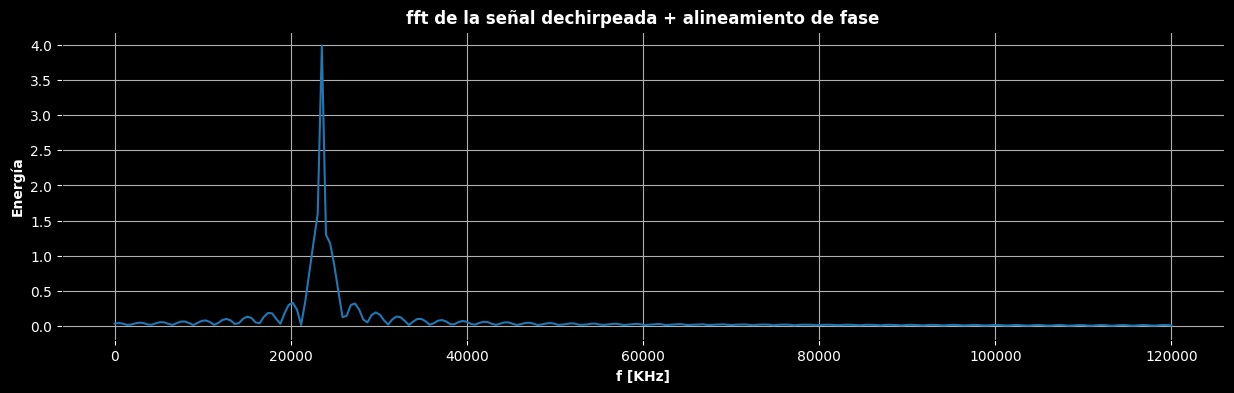

El símbolo recibido fue: 50


In [4]:
# Generadora del down-chirp base
def make_down_chirp():
    _time = np.linspace(0, Tc, num=samples_per_symbol)
    f_max = (N - 1) * Bw / N
    k = np.linspace(0, N, num=samples_per_symbol)
    f = np.linspace(0, -f_max, num=samples_per_symbol)
    t = (k*Ts) % Tc
    
    _chirp = np.exp(1j * 2 * np.pi * f * t/2)/np.sqrt(2**SF)
    _freq = f
    return _chirp, _time, _freq

# Actuálmente esto solo puede retornar el símbolo como valores discretos que coinciden exactamente con el símbolo, es un problema porque la variación es necesaria para el sistema de control que quiero realizar. Se podría medir la diferencia con el símbolo una vez obtenido con una correlación, pero sería preferible computacionalmente recuperar el símbolo como un valor flotante.
def dem_symbol(_symbol):
    _base_down_chirp, _, _ = make_down_chirp()
    _dechirped_simbol = _symbol * _base_down_chirp
    _symbol_fft = np.fft.fft(_dechirped_simbol)
    _CPA_symbol = np.abs(_symbol_fft[:int(len(_symbol_fft)*delta)]) + np.abs(_symbol_fft[int(len(_symbol_fft) - len(_symbol_fft)*delta):])
    _sufficient_observation = np.argmax(_CPA_symbol)
    return _CPA_symbol, (int(_sufficient_observation), float(np.max(_CPA_symbol)))


CPA, rx_symbol = dem_symbol(lora_symbol)
plot_signal('fft de la señal dechirpeada + alineamiento de fase', 'f [KHz]', 'Energía', np.linspace(0, Bw, len(CPA)), CPA, _ticks=True)
print ('El símbolo recibido fue: ' + str(rx_symbol[0]))

### Canal AWGN

Según los documentos oficiales de *Semtech*, la relación señal ruido (**SNR**) mínima aceptable para una transmisión por modulación LoRa dependerá del valor elegido para el SF según lo descrito en la siguiente tabla:

.

 <table style="border: 3px solid black; width: 100%; color: #0000000">
  <tr style="border: none;">
    <th style="background-color: #819B81;border: none; padding= none">Spreading Factor (SF)</th>
    <th style="background-color: #819B81;border: none; padding= none">Mínima SNR aceptable</th>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #D5DDD5;border: none;">6</td>
    <td style="background-color: #D5DDD5;border: none;">-5 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #B9C7B9;border: none;">7</td>
    <td style="background-color: #B9C7B9;border: none;">-7.5 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #D5DDD5;border: none;">8</td>
    <td style="background-color: #D5DDD5;border: none;">-10 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #B9C7B9;border: none;">9</td>
    <td style="background-color: #B9C7B9;border: none;">-12.5 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #D5DDD5;border: none;">10</td>
    <td style="background-color: #D5DDD5;border: none;">-15 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #B9C7B9;border: none;">11</td>
    <td style="background-color: #B9C7B9;border: none;">-17.5 dB</td>
  </tr>
  <tr style="border: none;">
    <td style="background-color: #D5DDD5;border: none;">12</td>
    <td style="background-color: #D5DDD5;border: none;">-20 dB</td>
  </tr>
</table> 

.

Como se puede apreciar esta tabla nos indica valores de SNR negativos, lo que implicaría que la comunicación se puede lograr incluso cuando la potencia del ruido supere a la de la señal. Para comprobar esto realizamos las siguientes simulaciones de monte carlo con símbolos aleatorios y SF 7, 9 y 11 donde buscaremos el BER para las SNR indicadas para cada uno de estos valores, SNR=0 dB y SNR=-20 dB.

In [5]:
def get_symbol_power():
    _base_up_chirp, _, _ = make_lora_symbol(0)
    return np.mean(np.abs(_base_up_chirp)**2)

def awgn_channel(_signal, _symbol_power, snr_db):
    _noise_power = _symbol_power / 10**(snr_db/10)
    _noise = (1 + 1j)*np.sqrt(_noise_power/2) * np.random.randn(len(_signal))
    return _signal + _noise

run_monte_carlo = False

def monte_carlo(_snr):
    _pe = 0
    _CPA = 0
    _symbol_power = get_symbol_power()
    for i in range(10000):
        _symbol = np.random.randint(low = 0, high = N)
        _lora_symbol, _, _ = make_lora_symbol(_symbol)
        _channel_output = awgn_channel(_lora_symbol, _symbol_power, _snr)
        _CPA, _rx_symbol = dem_symbol(_channel_output)
        if _rx_symbol[0] != _symbol:
            _pe += 1
    _pe = _pe/10000
    return _pe, _CPA


if run_monte_carlo:
    pe = [[7, 0, 0], [7, -7.5, 0], [7, -20, 0],
          [9, 0, 0], [9, -12.5, 0], [9, -20, 0],
          [11, 0, 0], [11, -17.5, 0], [11, -20, 0]]
    
    for i in range(9):
        set_sf(pe[i][0])
        pe[i][2], CPA = monte_carlo(pe[i][1])
        plot_signal('fft última iteración para SNR ' + str(pe[i][1]) + ' dB y SF ' + str(pe[i][0]), 'f [KHz]', 'Energía', np.linspace(0, Bw, len(CPA)), CPA, _ticks=True)
    
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title('Probabilidades de error según SFs y SNRs por simulación de monte carlo', fontdict={'color':'black', 'weight':'bold'})
    table = ax.table(cellText=pe,
                     colLabels=['SF', 'SNR [dB]', 'BER'],
                     loc='center',
                     cellLoc='center',
                     colColours=['#819B81']*3,
                     fontsize=20)
    row_colors = ['#D5DDD5', '#B9C7B9']
    for i in range(9):
        for j in range(3):
            table[(i+1, j)].set_facecolor(row_colors[i % 2]) 
    table.scale(1, 2)
    ax.axis('off')
    plt.show()

Se puede apreciar de los datos obtenidos que el BER para un SF específico incrementa al reducirse la SNR, lo que es de esperarse, pero el mismo es sorprendentemente bajo para SNR negativas, manteniéndose por debajo del 0.5% en los valores indicados por *Semtech* como SNR mínima soportada. Por otra parte, es también observable que al fijar la SNR y variar el SF, le BER es menor a mayor sea SF, lo que implíca que variar los valores de SF también nos puede ofrecer a cambio de un aumento del ancho de banda o del tiempo de transmisión, una mayor resistencia al ruido.

## Paquete LoRa:

El paquete LoRa es la política de "hand holding" entre el transmisor y el receptor de un sistema de comunicaciones LoRaWAN, y permite entre otras cosas que el receptor sepa cuando se inicia una transmisión y evitar así que decodifique ruido.

El paquete LoRa puede ser **explícito** o **implícito** donde el primero se usa para paquetes de datos de tamaño variable y el segundo es para tamaño fijo. El paquete, sea cual sea el modo elegido consiste de 3 partes:

- Preámbulo
- Start Frame Delimiter (SFD)
- Datos

El **Preámbulo** consiste en enviar un número predefinido de up-chirps base. El objetivo es que el receptor al decodificar un número específico alto de up-chirps sabrá que se está transmitiendo un paquete y que no es ruido, por ello el número de up-chirps debe ser lo suficientemente alto de modo que los datos no tiendan a contener patrones de este tipo. Luego de estos se transmiten 2 up-chirps modulados que indican el tamaño del mensaje transmitido, permitiendo así sincronizar el frame entre transmisor y receptor, esto último queda claro que solo se utiliza en casos donde el tamaño del paquete es desconocido para el receptor, es decir, transmisión explícita.

El **SFD** en algunos estudios se lo suele considerar parte del preámbulo y consiste de 2 down-chirps indicando el inicio de los datos, Esto es necesario, ya que se puede dar que el primer dato transmitido sea el mismo símbolo que el preámbulo siendo así imposible para el receptor diferenciarlo a menos que lleve la cuenta exacta del preámbulo sin haberse perdido ninguna lectura por ruido.


Datos empaquetados: [30, 65, 190, 15]


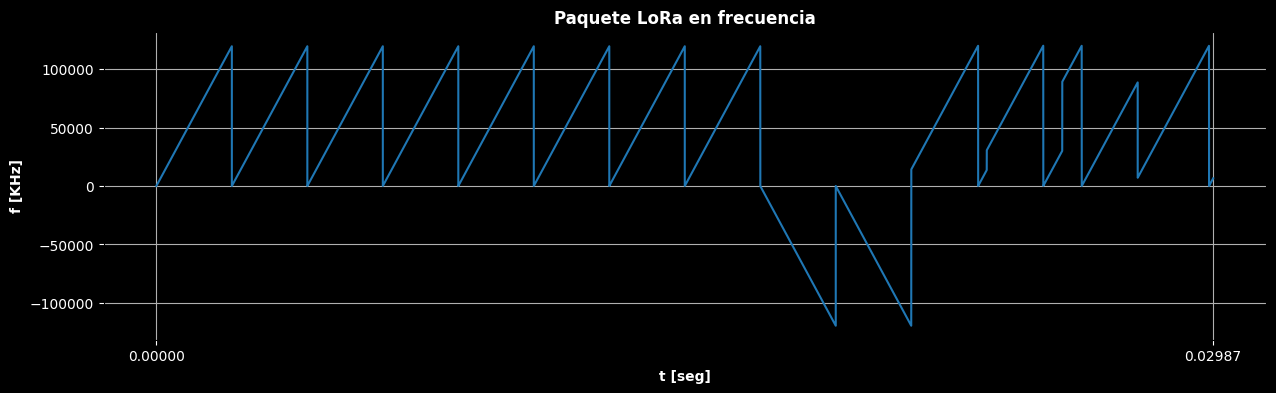

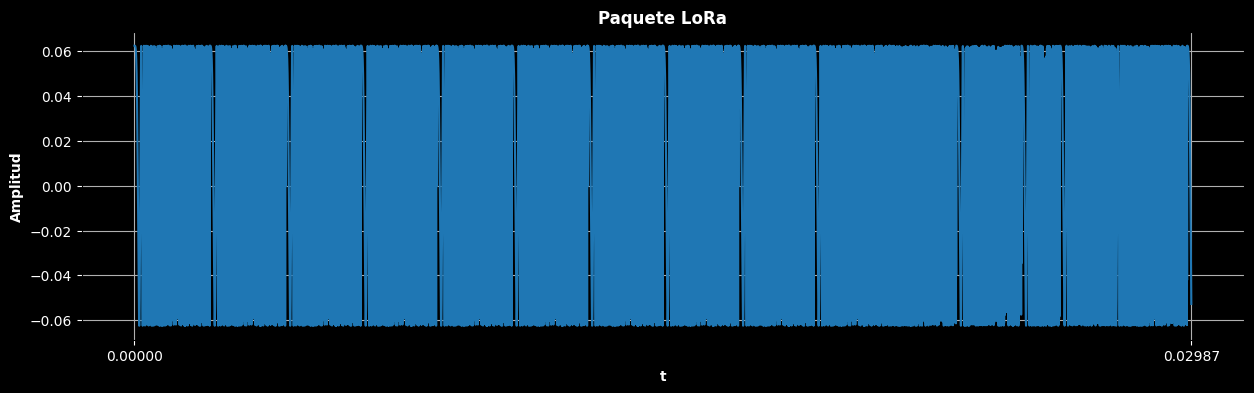

In [6]:
set_sf(8)

def build_preamble(size):
    # Preámbulo propiamente dicho
    _c, _t, _f = make_lora_symbol(0)
    _aux_f = _f
    _aux_t = _t
    _aux_c = _c
    
    for i in range(size - 1):
        _c = np.append(_c, _aux_c)
        _f = np.append(_f, _aux_f)
        _t = np.append(_t, _aux_t + _t[len(_t) - 1])
    
    # SDF
    _aux_c, _aux_t, _aux_f = make_down_chirp()
    for i in range(2):
        _c = np.append(_c, _aux_c)
        _f = np.append(_f, _aux_f)
        _t = np.append(_t, _aux_t + _t[len(_t) - 1])
        
    return _c, _t, _f

def build_lora_packet(_symbols, _preamble_size):
    _data, _time, _frequency = build_preamble(_preamble_size)
    
    for _sym in _symbols:
        _d, _t, _f = make_lora_symbol(_sym)
        _data = np.append(_data, _d)
        _frequency = np.append(_frequency, _f)
        _time = np.append(_time, _t + _time[len(_time) - 1])
    
    return _data, _time, _frequency


data_length = 4  
datos = [30, 65, 190, 15]
preamble_size = 8
Lora_packet, LoRa_pack_time, LoRa_pack_freq = build_lora_packet(datos, preamble_size)

print('Datos empaquetados: ' + str(datos))
plot_signal('Paquete LoRa en frecuencia', 't [seg]', 'f [KHz]', LoRa_pack_time, LoRa_pack_freq)
plot_signal('Paquete LoRa', 't', 'Amplitud', LoRa_pack_time, np.real(Lora_packet))
        

### Demodulación de paquete

En un principio la demodulación de un paquete LoRa se puede llevar a cabo de la misma manera en que se demodulaba un símbolo, pero hay que tener en cuenta 2 pasos extra:

- Separar el preámbulo de los datos
- Asegurar que la lectura está en fase con la transmisión

Para el primero es para lo que existe el SDF, ya que idealmente, al demodular con un down-chirp todos los símbolos tendrán una frecuencia constante que se observará tras realizar la fft, pero el down-chirp, al tener una naturaleza opuesta, presenta esta propiedad con un up-chirp. Así idealmente bastaría con realizar el producto de cada símbolo con un down-chirp, y aquellos que no presenten un impulso unitario en frecuencia serán el SFD, con lo que le procede serán los datos.

En un canal real el ruido distorsiona la frecuencia de modo que ningún símbolo se recibirá como un up-chirp ideal, y su frecuencia se verá alterada como ya se discutió previamente, aun así es posible estimar si el símbolo es un up-chirp o un down-chirp realizando una correlación. La misma se realiza con un down-chirp, ya que en un principio los up-chirps se pueden presentar en $2^{SF}$ formas distintas, mientras que el down-chirp solo una, por lo que basta con realizar la correlación con un down-chirp y aquellos símbolos que den mayor valor serán los down-chirps originales. Para simplificar la comparación se puede realizar el cuadrado de los resultados para así alejar los valores correctos de los incorrectos lo más posíble.


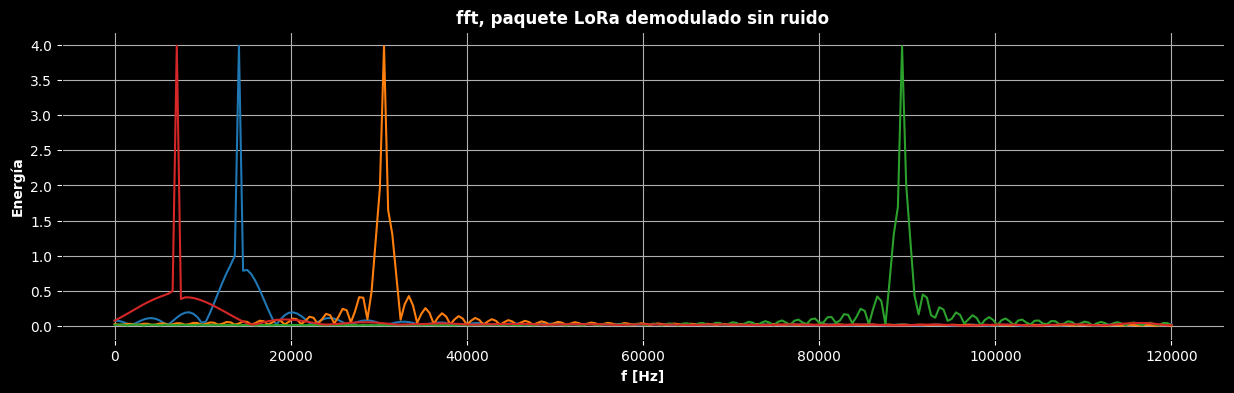

Los símbolos recibidos por el canal no ruidoso fueron: [30, 65, 190, 15]


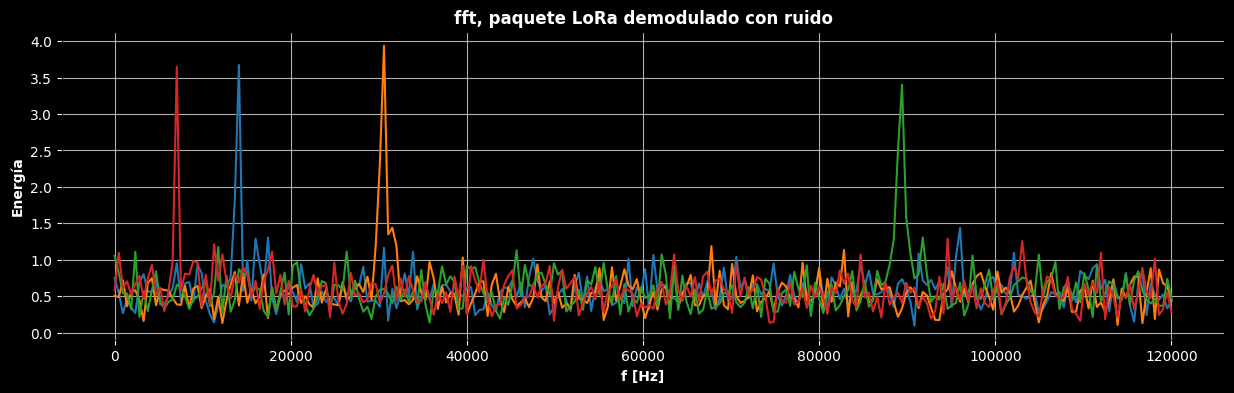

Los símbolos recibidos por el canal ruidoso fueron: [30, 65, 190, 15]


In [7]:
def dem_packet_on_phase(_packet):
    _packet_symbols_no = data_length + preamble_size + 2
    _packet_CPAs = []
    _packet_observations = []
    _down_chirp, _, _ = make_down_chirp()
    _finished_preamble = False
    
    for i in range(_packet_symbols_no):
        # select single symbol
        _symbol = _packet[i*samples_per_symbol: (i + 1)*samples_per_symbol]
        # check if it's a down-chirp
        _corr = np.correlate(_symbol, _down_chirp, mode='same')
        if np.max(np.abs(_corr)**2) >= 10:
            # Esto es un down_chirp del SFD (A menos que nos hayamos excedido en la potencia del ruido)
            _aux_observations = -1
            _finished_preamble = True
            continue
        if _finished_preamble:
            # Demodulate symbol
            _aux_CPA, _aux_observations = dem_symbol(_symbol)
            # Save demodulated values
            _packet_CPAs.append(_aux_CPA)
            _packet_observations.append(_aux_observations[0])
    
    _packet_CPAs = np.asarray(_packet_CPAs)
    _packet_observations = np.asarray(_packet_observations)
    return _packet_CPAs, _packet_observations


packet_CPAs, rx_symbols = dem_packet_on_phase(Lora_packet)
noisy_packer_CPAs, noisy_rx_symbols = dem_packet_on_phase(awgn_channel(Lora_packet, get_symbol_power(), -8))

plot_signal('fft, paquete LoRa demodulado sin ruido', 'f [Hz]', 'Energía', np.linspace(0, Bw, len(packet_CPAs[0])), *packet_CPAs, _ticks=True)
print('Los símbolos recibidos por el canal no ruidoso fueron: ' + str([round(rx_symbols[i]) for i in range(len(rx_symbols))]))

plot_signal('fft, paquete LoRa demodulado con ruido', 'f [Hz]', 'Energía', np.linspace(0, Bw, len(noisy_packer_CPAs[0])), *noisy_packer_CPAs, _ticks=True)
print('Los símbolos recibidos por el canal ruidoso fueron: ' + str([round(noisy_rx_symbols[i]) for i in range(len(noisy_rx_symbols))]))

Por otra parte, también debemos asegurar que el receptor esté en fase con el transmisor, para ello el preámbulo cumple un papel fundamental. Inicialmente, desde el preámbulo se transmite el símbolo 0 multiples veces, pero si la lectura se hace fuera de fase el símbolo que se obtendrá cambiará, observando como se ve el símbolo 0 (up-chirp base) al desfasarse, teniendo el mismo otro up-chirp base delante de él, este se demodulará como un símbolo distinto a 0, y lo mismo ocurrirá con el siguiente, y el siguiente hasta finalizar el preámbulo. De este modo el receptor, al notar que recibió multiples veces el mismo símbolo, incluso si este no es un 0, puede saber que la transmisión se inició, y el símbolo que logra leer le indica cuan desfasado se encuentra del transmisor, luego al recibir un símbolo diferente comprobará si se trata de un down-chirp, en cuyo caso considerará que a continuación vendrá el mensaje.

En el caso de transmisión continua será útil para el receptor guardar el buffer de su última lectura, de modo que si el defasaje es tal que la transmisión inicia en una lectura y finaliza en otra, aún tenga la capacidad de recuperar todo el mensaje. Dado que en la simulación se tendrá la libertad de retrasar o adelantar la señal se guardarán 3 buffers, uno de los cuales estará vacío según el tipo de defasaje que se utilizó.

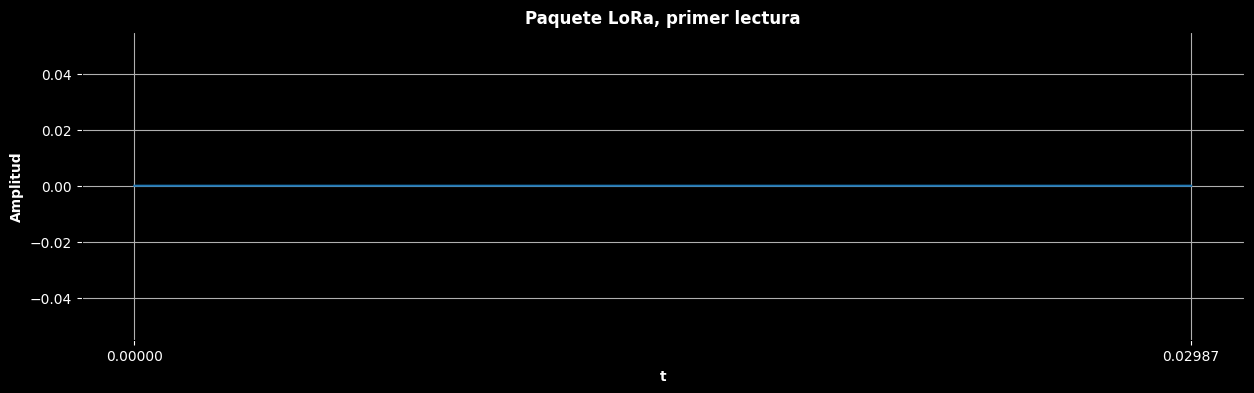

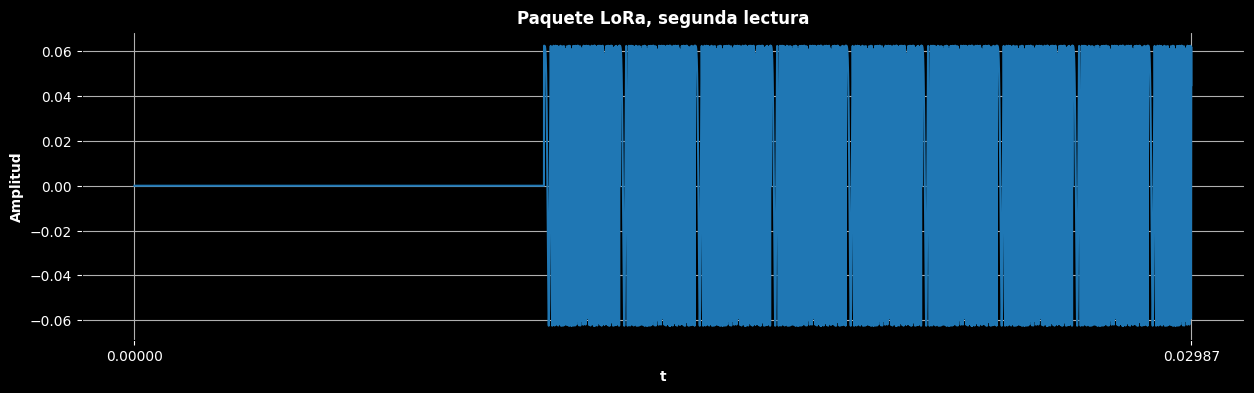

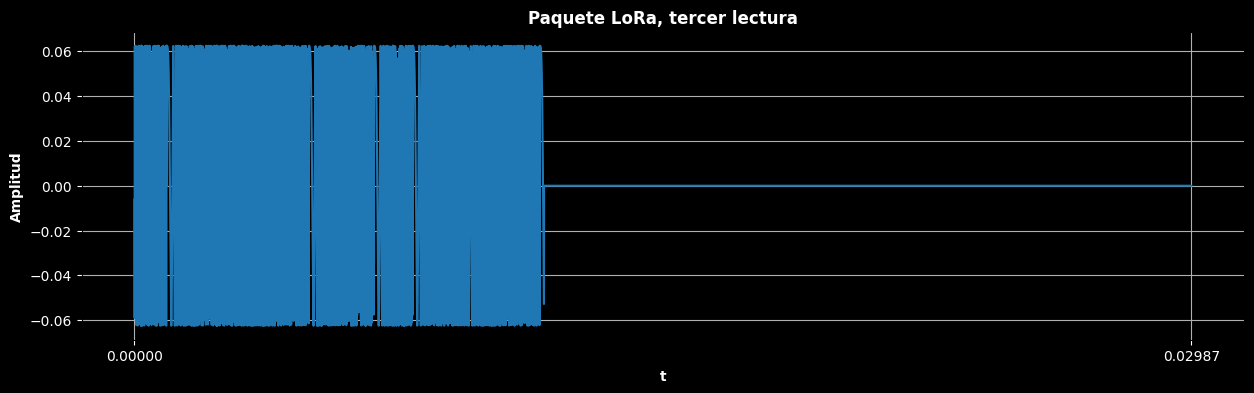

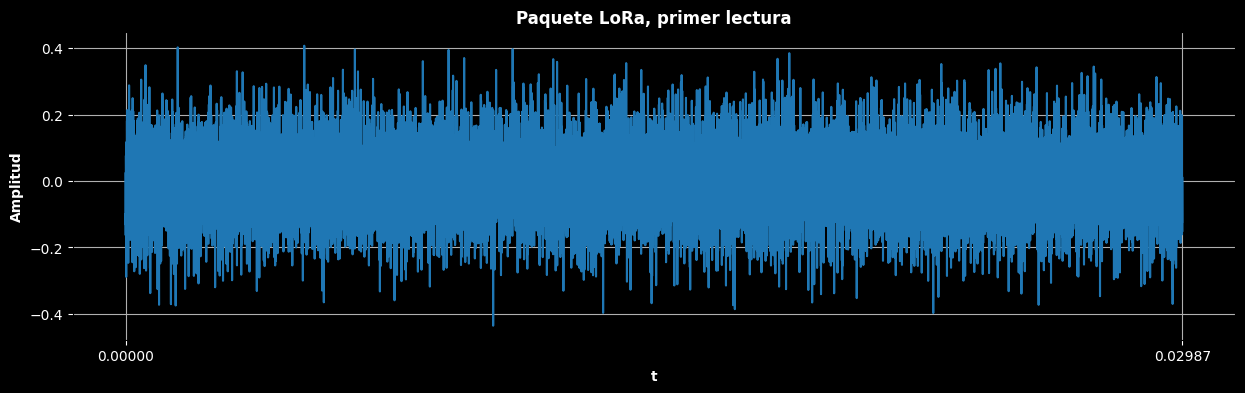

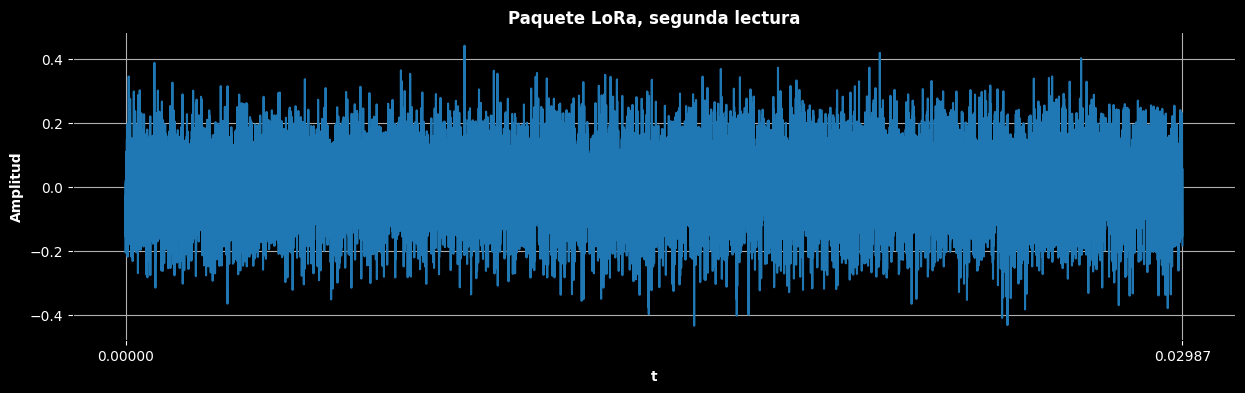

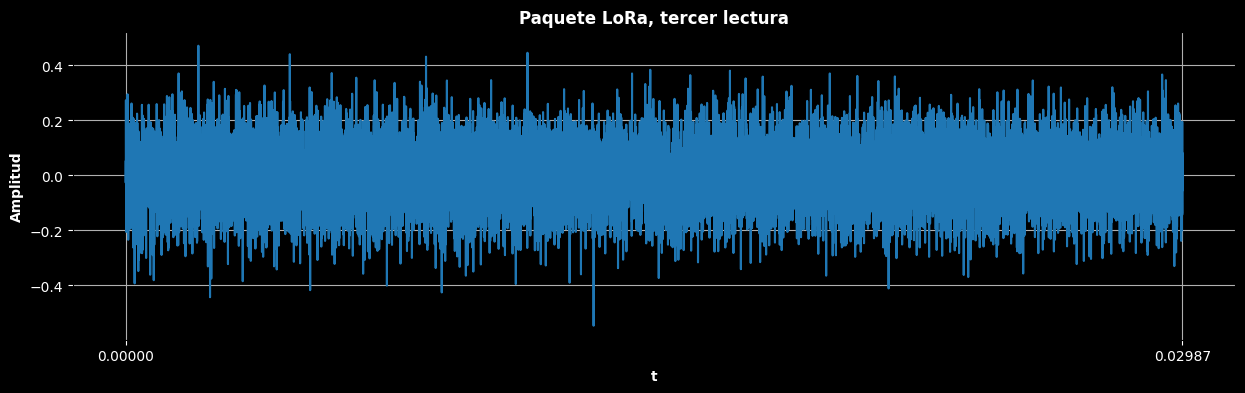

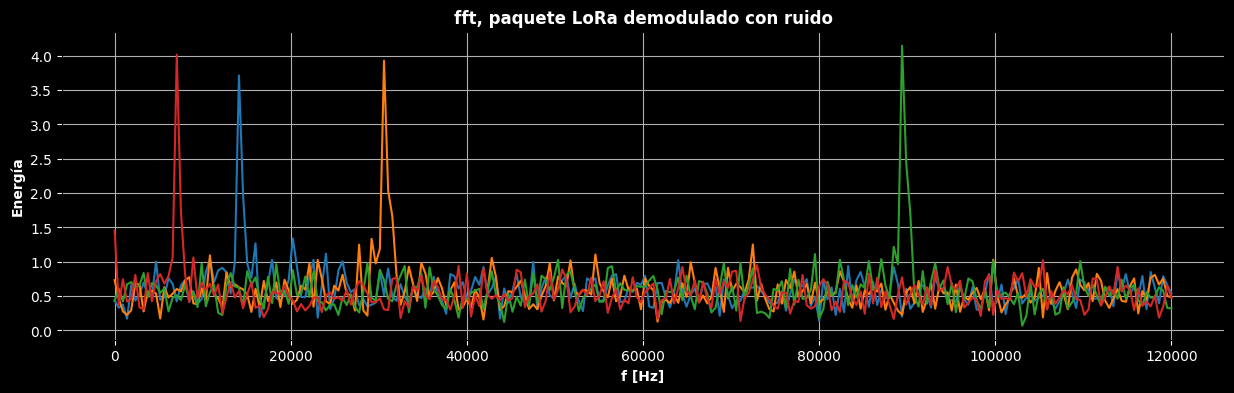

Los símbolos recibidos por el canal ruidoso fueron: [30, 65, 190, 15]


In [8]:
def add_phase(_signal, _phase):
    if np.abs(_phase) >= len(_signal):
        print('Advertencia: un defasaje mayor al tamaño del paquete puede provocar errores en la simulación')
    _observed_signal = [[0]*len(_signal), [0]*len(_signal), [0]*len(_signal)]
    for i in range(len(_signal)):
        j = i - _phase
        if j < 0:
            _observed_signal[0][len(_signal) + j] = _signal[i]
        elif j >= len(_signal):
            _observed_signal[2][j - len(_signal)] = _signal[i]
        else:
            _observed_signal[1][j] = _signal[i]
    return _observed_signal


# Variables necesarias para la demodulación fuera de fase. Son globales ya que sus valores deben mantenerse entre llamados consecutivos.
stored_buffer = [0]*data_length
stored_CPAs = []
stored_buffer_index = 0
correction_symbol = -1
last_symbol = [-1, 0]
repetitions = 0
in_preamble_noise_tolerance = N/8
noisy_preamble = 0
on_data = False
on_sdf = False
on_preamble = False
stored_samples = []

def dem_lora_packet_out_of_phase(_packet):
    global stored_buffer, stored_CPAs, stored_buffer_index
    global correction_symbol, last_symbol, repetitions, noisy_preamble
    global on_data, on_sdf, on_preamble
    global stored_samples
    _packet_symbols_no = data_length + preamble_size + 2
    _down_chirp, _, _ = make_down_chirp()
    _packet_CPAs = np.asarray([])
    _return_data = []
    
    
    for i in range(_packet_symbols_no):
        # Seleccionamos un único símbolo
        _symbol = []
        if on_data or on_sdf or on_preamble:
            # Si conocemos el defasaje hacemos la corrección al leer
            if correction_symbol == -1:
                correction_symbol = last_symbol[0]
            if i*samples_per_symbol - int(correction_symbol/delta) < 0:
                _symbol = np.append(stored_samples, _packet[:samples_per_symbol - int(correction_symbol/delta)])
            else:
                # Si sobraron muestras de la demodulación anterior las usamos como inicio de nuestro paquete
                _symbol = _packet[i*samples_per_symbol - int(correction_symbol/delta): (i + 1)*samples_per_symbol - int(correction_symbol/delta)]
            stored_samples = _packet[(i + 1)*samples_per_symbol - int(correction_symbol/delta):]
            last_symbol = [0, 0]
        else:
            # Si no conocemos el defasaje leemos normalmente
            _symbol = _packet[i*samples_per_symbol: (i + 1)*samples_per_symbol]
        # Guardamos las muestras sobrantes en caso de que sobren
        _aux_CPA, _aux_observation = dem_symbol(_symbol)
        
        if on_data:
            stored_buffer_index += 1
            # Si sabemos que ya estamos recibiendo datos llevamos la cuenta de cuantos datos hemos recibido para así saber cuando hemos finalizado de leer el mesnaje
            if stored_buffer_index >= data_length:
                on_data = False
                _return_data = stored_buffer
                _packet_CPAs = np.asarray(stored_CPAs)
                stored_buffer_index = 0
                stored_CPAs = []
                last_symbol = [-1, 0]
                correction_symbol = -1
            else:
                # Si el mensaje no está completo guardamos el dato leído
                stored_buffer[stored_buffer_index] = _aux_observation
                stored_CPAs.append(_aux_CPA)
            continue
        elif on_sdf:
            # Si estamos en la SDF esperamos recibir down-chirps
            _corr = np.correlate(_symbol, _down_chirp, mode='same')
            if not np.max(np.abs(_corr)**2) >= 10:
                # Si lo que recibimos no es un down-chirp entonces ya inició la transmisión de datos
                on_sdf = False
                on_data = True
                stored_buffer[0] = _aux_observation
                stored_CPAs.append(_aux_CPA)
            continue
        elif on_preamble:
            # Si estamos en el preámbulo debemos verificar si el símbolo no es un down-chirp, en caso de serlo sabemos que inicio el SDF.
            _corr = np.correlate(_symbol, _down_chirp, mode='same')
            if np.max(np.abs(_corr)**2) >= 10:
                on_preamble = False
                on_sdf = True
                noisy_preamble = 0
                continue
            elif _aux_observation[0] != last_symbol[0]:
                # Si no es un down-chirp asumimos que seguimos en el preámbulo, con lo que verificamos si el símbolo que recibimos sigue siendo el mismo
                noisy_preamble += np.abs(_aux_observation[0] - last_symbol[0])
                if noisy_preamble > in_preamble_noise_tolerance:
                    # Si leemos muchos símbolos erroneos asumimos que nunca estuvimos realmente en el preámbulo 
                    on_preamble = False
                    noisy_preamble = 0
                continue
        elif _aux_observation[0] == last_symbol[0]:
            # Si aún no entramos al preámbulo, pero recibimos el mismo símbolo contamos la cantidad de repeticiones 
            repetitions += 1
            if repetitions > preamble_size/2:
                # Si se repitieron suficientes veces sabremos que entramos al preámbulo. Usamos preamble_size/2 porque el defasaje y el ruido pueden hacernos perder 1 o 2 símbolos.
                on_preamble = True
                repetitions = 0
            continue
        # Si ninguno de los casos previos se cumplen guardamos el símbolo por si es el primer símbolo del preámbulo.
        last_symbol = _aux_observation
    
    return _packet_CPAs, _return_data

out_phase_lora_packet = add_phase(Lora_packet, -5555)

plot_signal('Paquete LoRa, primer lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[0]))
plot_signal('Paquete LoRa, segunda lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[1]))
plot_signal('Paquete LoRa, tercer lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[2]))

for i in range(3):
    out_phase_lora_packet[i] = awgn_channel(out_phase_lora_packet[i], get_symbol_power(), -8)


plot_signal('Paquete LoRa, primer lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[0]))
plot_signal('Paquete LoRa, segunda lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[1]))
plot_signal('Paquete LoRa, tercer lectura', 't', 'Amplitud', LoRa_pack_time, np.real(out_phase_lora_packet[2]))


cpa_0, obs_0 = dem_lora_packet_out_of_phase(out_phase_lora_packet[0])
cpa_1, obs_1 = dem_lora_packet_out_of_phase(out_phase_lora_packet[1])
cpa_2, obs_2 = dem_lora_packet_out_of_phase(out_phase_lora_packet[2])

Packet_CPA = [*cpa_0, *cpa_1, *cpa_2]
obs = [*obs_0, *obs_1, *obs_2]
if len(Packet_CPA) > 0:
    plot_signal('fft, paquete LoRa demodulado con ruido', 'f [Hz]', 'Energía', np.linspace(0, Bw, len(Packet_CPA[0])), *Packet_CPA, _ticks=True)
    print('Los símbolos recibidos por el canal ruidoso fueron: ' + str([round(obs[i][0]) for i in range(4)]))

### Comunicaciónes satelitales (DtS)

Existen ya varios estudios que confirman la posibilidad de establecer comunicaciones entre un dispositivo LoRa con un satélite de baja orbita terrestre (LEO), pero este tipo de comunicaciones conlleva una nueva problemática, el efecto Doppler.

El efecto Doppler causado por el movimiento de un satélite relativo a la rotación de la tierra genera tanto cambios en la duración en el tiempo de los símbolos, como cambios en las frecuencias de los mismos. Estos cambios en frecuencia se presentan de 2 maneras, el efecto Doppler estático, es decir la diferencia entre la duración de los símbolos observada al iniciar la recepción de un paquete, y el efecto Doppler dinámico, que son los cambios en frecuencia adicionales que ocurren durante la recepción del paquete.

Como ya se mencionó este efecto se debe a la diferencia de movimiento entre la tierra y el satélite que la orbita, para poder simular esto debemos comprender matemáticamente como calcularlo.

Iniciamos nuestro análisis por calcular la distáncia estática entre el dispositivo LoRa y el satélite. De antemano conocemos ciertas constantes que serán de utilidad, como el radio de la tierra (R) y la elevación del satélite con respecto a la tierra (H), con ello podemos decir que la distancia entre el satélite y el dispositivo es:

$$d(E) = R \left [ \sqrt{\left (\frac{H + R}{R} \right )^2 - cos^2(E)} - sin(E)\right ]$$ 

Donde E es el ángulo de elevación en grados del satélite con respecto al dispositivo, o más bien, al plano tangente a la tierra que se centra en el dispositivo. Este se puede calcular como:

$$E(d) = sin^{-1}\left (\frac{H^2 + 2HR - d^2}{2dR}\right )$$ 

Por otra parte, podemos definir la circunferencia del arco de la corteza terrestre entre el dispositivo y la proyección del satélite sobre la misma como:

$$d_g(E) = R\alpha(E) = R sin^{-1}\left (\frac{d(E)cos(E)}{R + H}\right )$$

Donde $\alpha$ es el ángulo en radianes concéntrico a la tierra, entre el dispositivo y el satélite.

Por último, dado H es posible calcular el tiempo máximo de visibilidad de satélite, el cúal por su parte, dependerá de $Lim_{E \rightarrow 0}d_g(E)$, al cual calcularemos con $ E = 1 $ para simplificar el estúdio.

$$\tau = 2\frac{d_g(E=1)}{v}$$

Donde $v$ es la velocidad orbital del satélite tal que:

$$v = \sqrt{\frac{gR}{1+\frac{H}{R}}}$$

Con todo esto ya podemos calcular el efecto Doppler sobre nuestros paquetes, de modo que el efecto Doppler estático será:

$$F_E(t) = F_R(t) - F_c$$

y el dinámico será:

$$F_D(t) = \frac{d(F_E(t))}{dt}$$

Del efecto estático cabe aclarar que $F_R$ es la frecuencia recibida, mientras que $F_C$ es la transmitida, y con la segunda se puede calcular la primera como:

$$F_R(t)=F_C\frac{1}{1 + \frac{v}{c}cos(\beta(t))}$$

Donde $\beta$ es el ángulo entre el vector velocidad del satélite y el vector dirección del dispositivo hacia el satélite, y se calcula como:

$$cos(\beta(t)) = \frac{sin(\omega(t))}{\sqrt{\left ( 1 + \frac{H}{R} \right )^2 - 2 \left ( 1 + \frac{H}{R}\right )cos(\omega(t)) + 1}}$$

Y $\omega$ se expresa como:

$$\omega(t) = t\sqrt{\frac{g}{R}}\left ( 1 + \frac{H}{R}\right )^{-\frac{3}{2}}$$


In [9]:
symbol = 20
signal, time, _ = make_lora_symbol(symbol)

def doppler_simple(_signal, _factor_estatico, _factor_dinamico, _n_symbols = 1):
    _old_t = np.linspace(0, Tc * _n_symbols, samples_per_symbol * _n_symbols, endpoint=False)
    # El periodo del chirp cambia de Tc a Tc*_factor_doppler_estático por el efecto estático
    _new_t = np.linspace(0, (Tc * _factor_estatico) * _n_symbols, len(_old_t))
    # Luego cada muestra transmitida también se desplaza en el tiempo por el efecto dinámico (Lo que también afecta al periodo del chirp)
    for _i in range(len(_new_t)):
        _new_t[_i] += _factor_dinamico*_i
    _signal_doppler = np.interp(_new_t, _old_t, _signal)
    #plot_signal('', '', '', _new_t, np.real(_signal_doppler))
    return _signal_doppler, _new_t


Iniciamos por estudiar el caso en el que solo nos afecta el efecto Doppler estático:

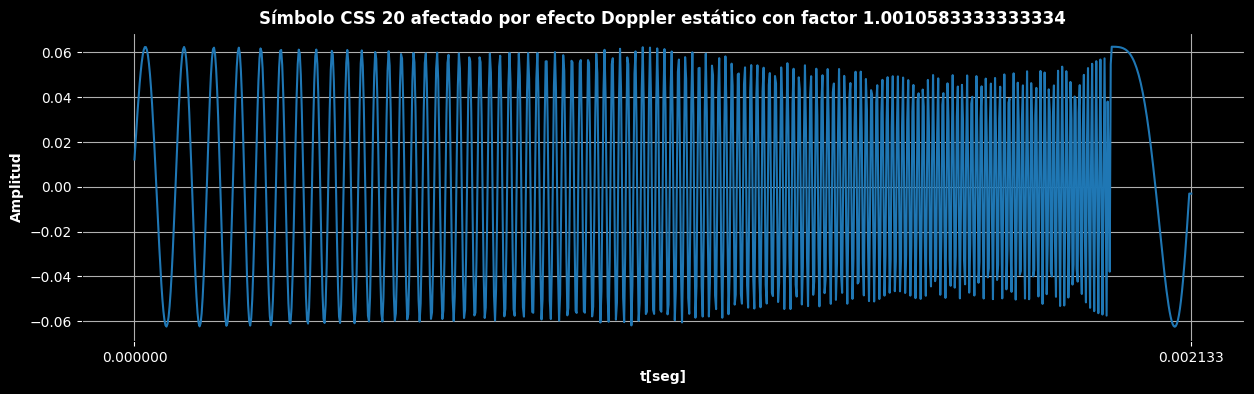

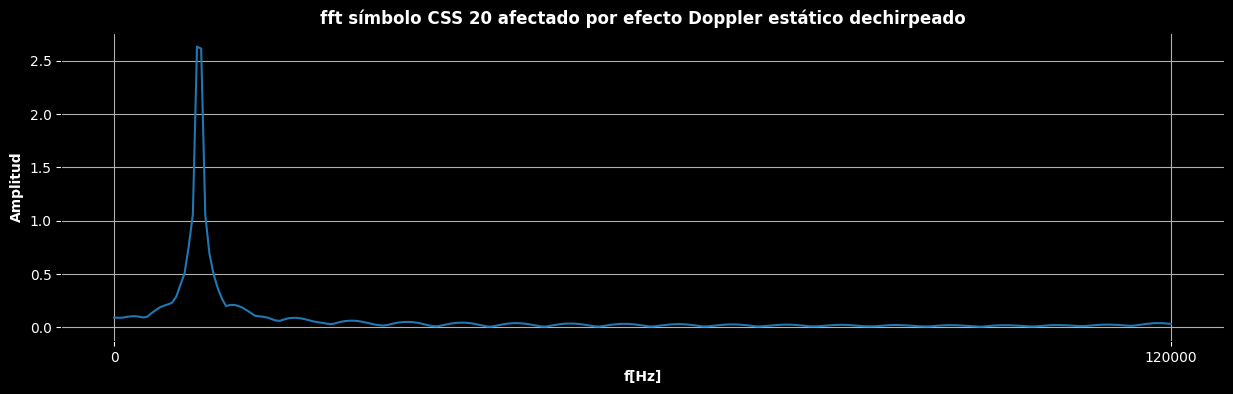

El símbolo leído fue: 20


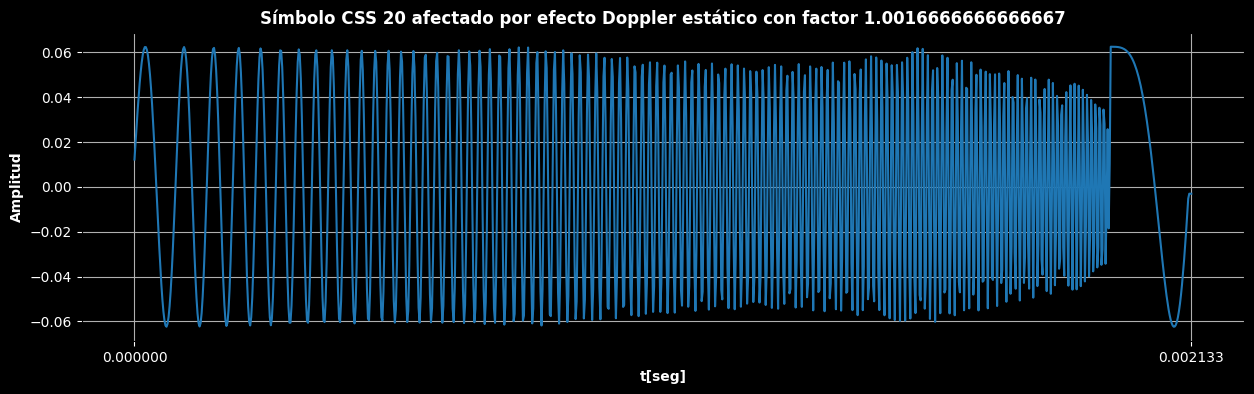

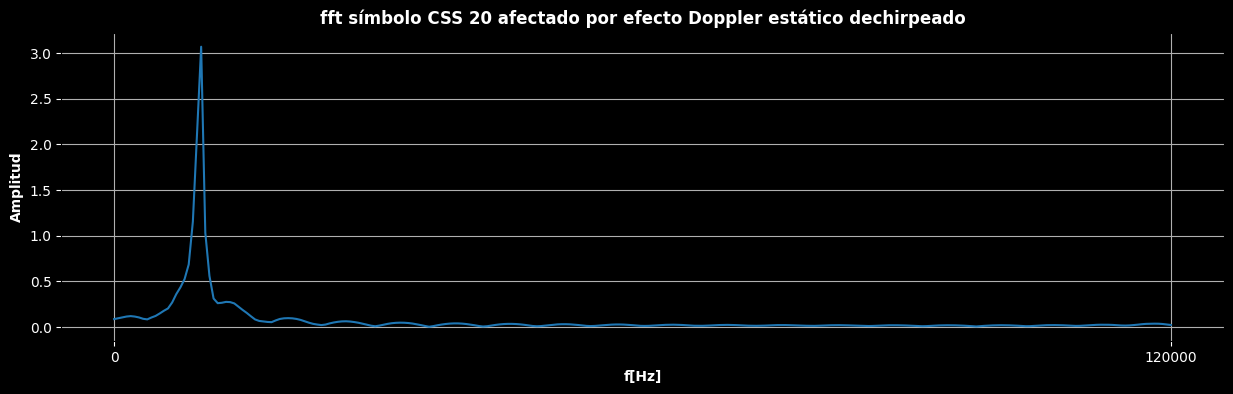

El símbolo leído fue: 21


In [10]:
static_factor = (Bw+127)/Bw
doppler_signal, _ = doppler_simple(signal, static_factor, 0)
plot_signal('Símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático con factor ' + str(static_factor), 't[seg]', 'Amplitud', time, np.real(doppler_signal))
CPA, rx_symbol = dem_symbol(doppler_signal)
plot_signal('fft símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático dechirpeado', 'f[Hz]', 'Amplitud', np.linspace(0, Bw, len(CPA)), CPA)
print('El símbolo leído fue: ' + str(rx_symbol[0]))

static_factor = (Bw+200)/Bw
doppler_signal, _ = doppler_simple(signal, static_factor, 0)
plot_signal('Símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático con factor ' + str(static_factor), 't[seg]', 'Amplitud', time, np.real(doppler_signal))
CPA, rx_symbol = dem_symbol(doppler_signal)
plot_signal('fft símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático dechirpeado', 'f[Hz]', 'Amplitud', np.linspace(0, Bw, len(CPA)), CPA)
print('El símbolo leído fue: ' + str(rx_symbol[0]))

Se nota de lo anterior que el efecto estático no es muy destructivo, se requiere una desviación de módulo mayor a la mitad de la distancia en frecuencia inicial entre símbolos para modificar la lectura original, aún así a mayor la desviación otros problemas empiezan a surgir, por un lado al incrementar mucho la frecuencia la misma alcanza valores que pueden superar los límites estipulados por el teoréma de muestréo, por otra parte, si el receptor asume que la duración del símbolo es la misma cuando el mismo se acorta por un aumento de la frecuencia, el mismo leerá un tramo de ruido puro (o 0 si no hay ruido) que asumirá como parte del símbolo y afectará la lectura, esto último será un problema más notable al trabajar con paquetes.

A continuación se observa el símbolo afectado por un factor doppler estático mucho mayor, se espera ver una deformación en frecuencia que aclare que el efecto causa más que una simple desviación.

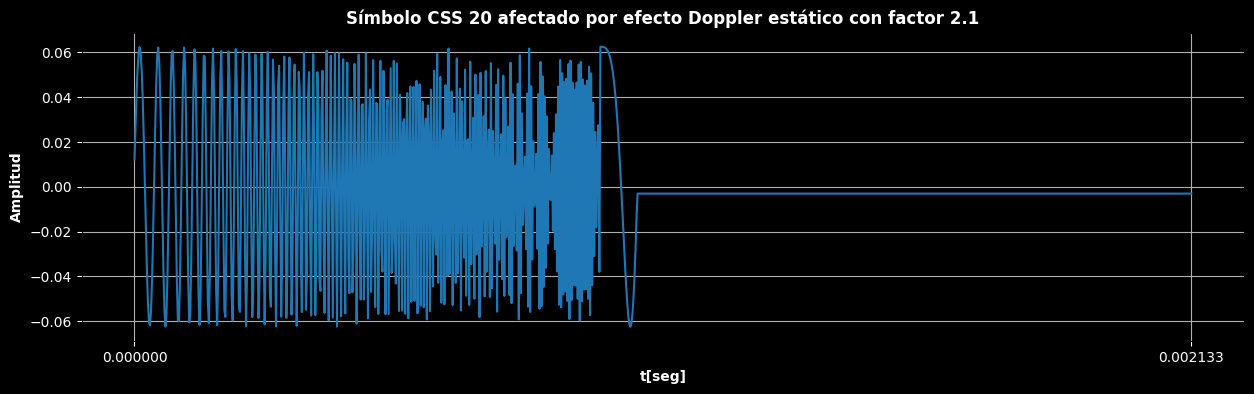

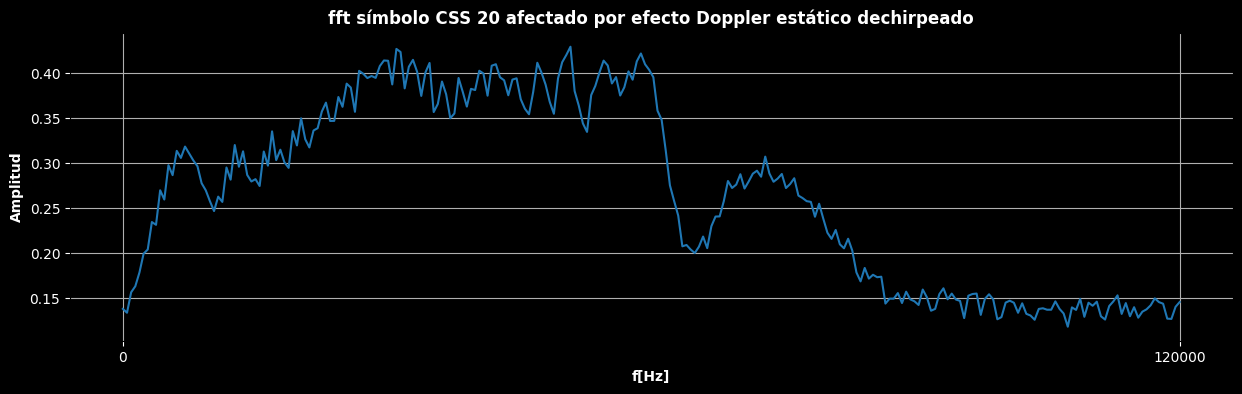

El símbolo leído fue: 108


In [11]:
static_factor = 2.1
doppler_signal, _ = doppler_simple(signal, static_factor, 0)
plot_signal('Símbolo CSS ' + str(20) + ' afectado por efecto Doppler estático con factor ' + str(static_factor), 't[seg]', 'Amplitud', time, np.real(doppler_signal))
CPA, rx_symbol = dem_symbol(doppler_signal)
plot_signal('fft símbolo CSS ' + str(20) + ' afectado por efecto Doppler estático dechirpeado', 'f[Hz]', 'Amplitud', np.linspace(0, Bw, len(CPA)), CPA)
print('El símbolo leído fue: ' + str(rx_symbol[0]))

Ahora analizaremos el caso del efecto Doppler dinámico.

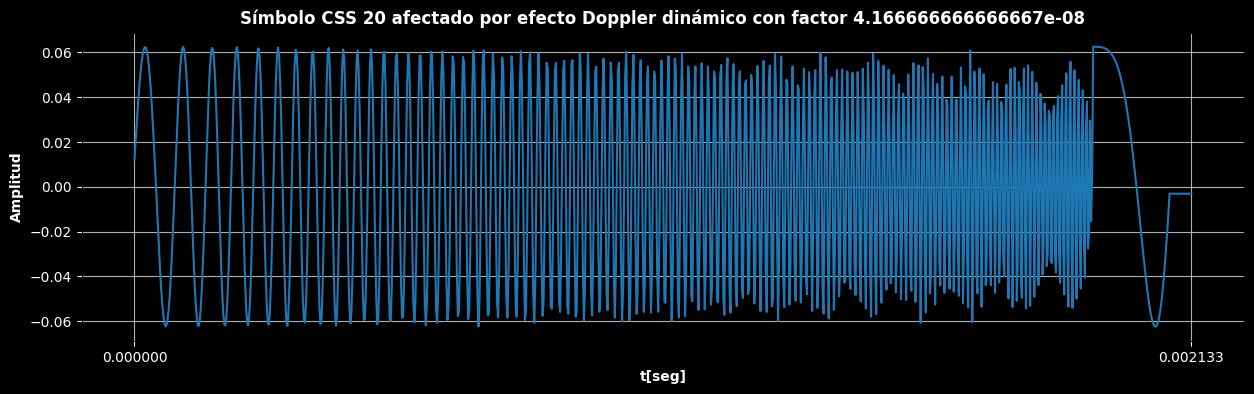

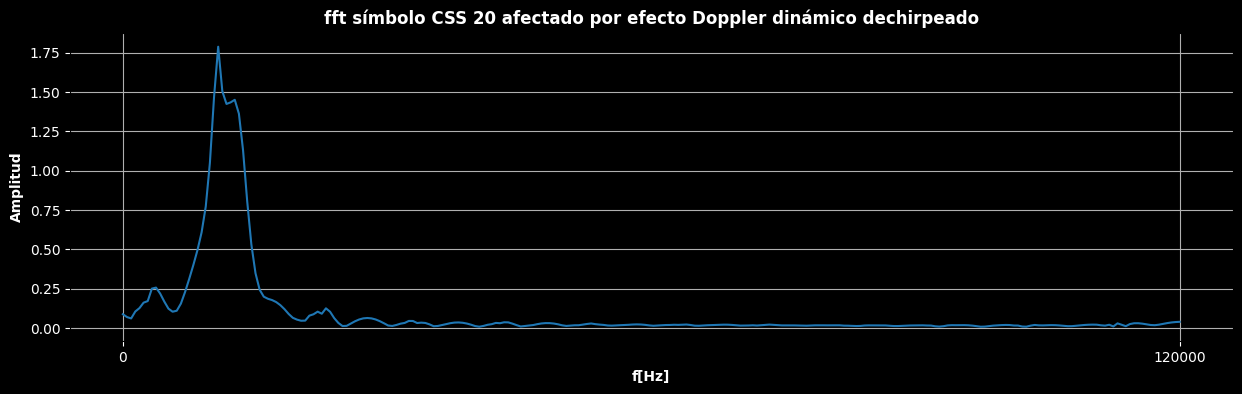

El símbolo leido fue: 23


In [12]:
dynamic_factor = 0.005/Bw
doppler_signal, _ = doppler_simple(signal, 1, dynamic_factor)
plot_signal('Símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler dinámico con factor ' + str(dynamic_factor), 't[seg]', 'Amplitud', time, np.real(doppler_signal))
CPA, rx_symbol = dem_symbol(doppler_signal)
plot_signal('fft símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler dinámico dechirpeado', 'f[Hz]', 'Amplitud', np.linspace(0, Bw, len(CPA)), CPA)
print('El símbolo leido fue: ' + str(rx_symbol[0]))

Con el efecto dinámico se observa un cambio más destructivo en frecuencia. Esto es de esperarse ya que la variación en el tiempo del efecto doppler provoca que se barran múltiples frecuencias, y la señal dechirpeada ya no será de frecuencia constante.

Por último observamos un caso con efecto doppler de ambas naturalezas. 

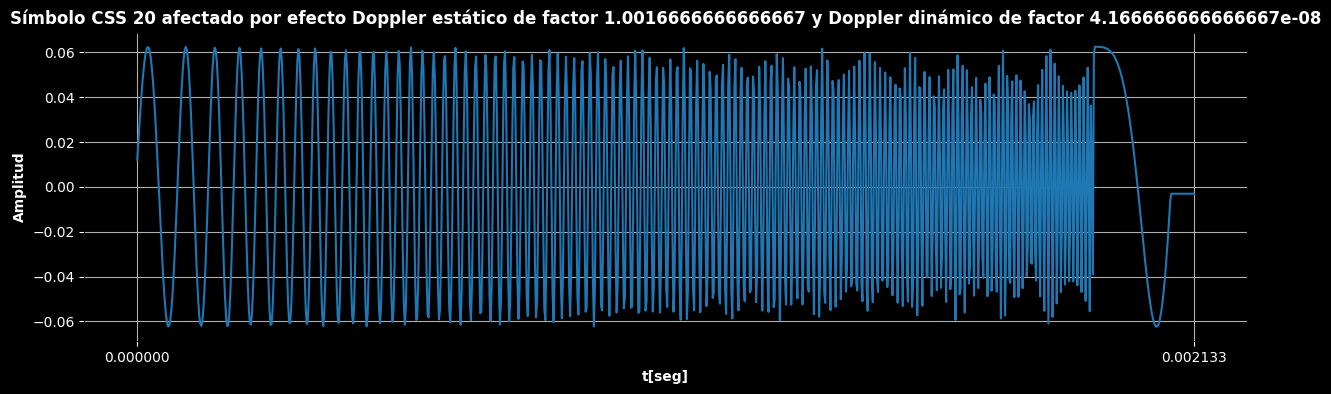

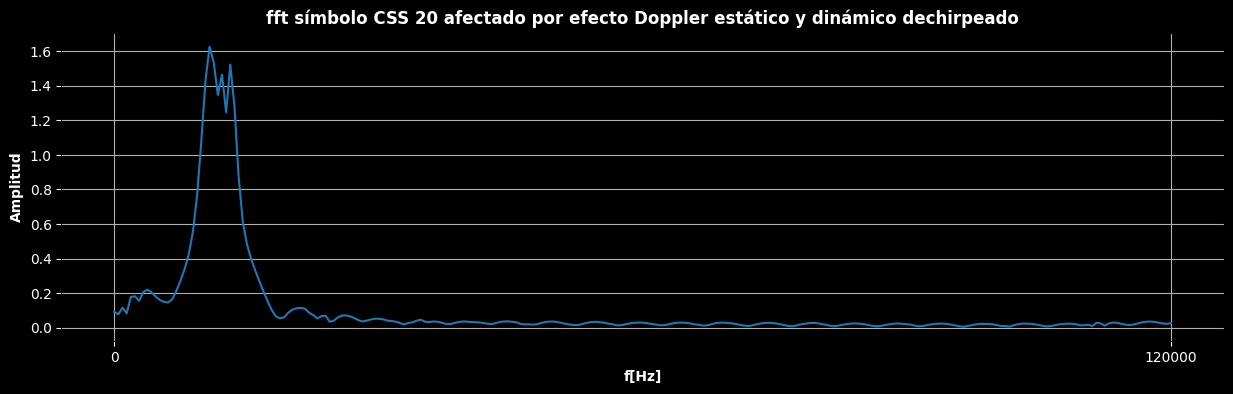

El símbolo leido fue:23


In [13]:
static_factor = (Bw+200)/Bw
dynamic_factor = 0.005/Bw
doppler_signal, _ = doppler_simple(signal, static_factor, dynamic_factor)
plot_signal('Símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático de factor ' + str(static_factor) + ' y Doppler dinámico de factor ' + str(dynamic_factor), 't[seg]', 'Amplitud', time, np.real(doppler_signal))
CPA, rx_symbol = dem_symbol(doppler_signal)
plot_signal('fft símbolo CSS ' + str(symbol) + ' afectado por efecto Doppler estático y dinámico dechirpeado', 'f[Hz]', 'Amplitud', np.linspace(0, Bw, len(CPA)), CPA)
print('El símbolo leido fue:' + str(rx_symbol[0]))

### Análisis caso de un paquete

El mensaje transmitido fue [30, 65, 190, 15]


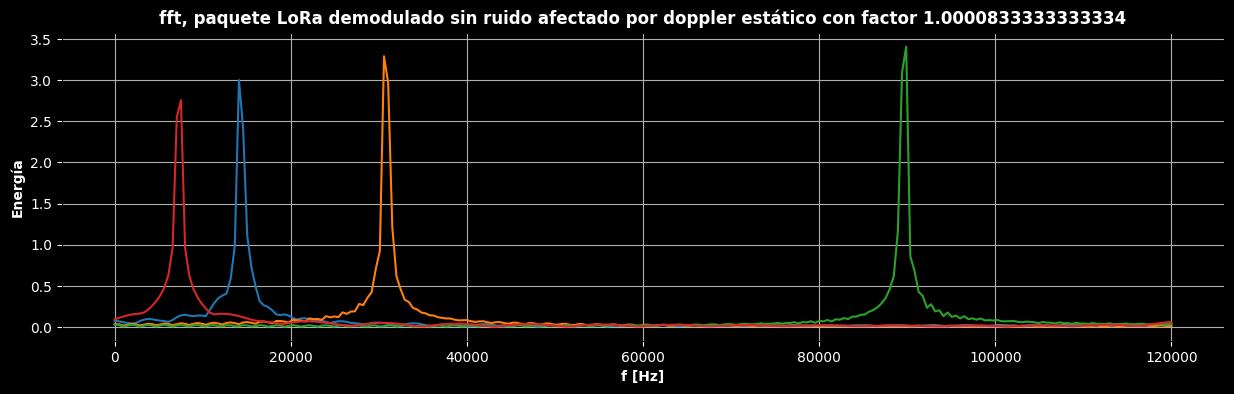

Los símbolos recibidos fueron: [30, 65, 191, 16]


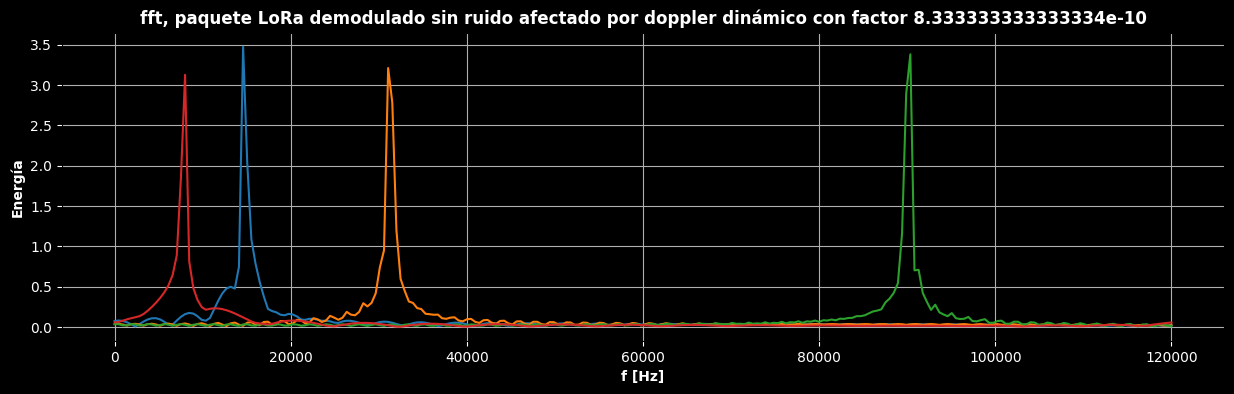

Los símbolos recibidos fueron: [31, 66, 192, 17]


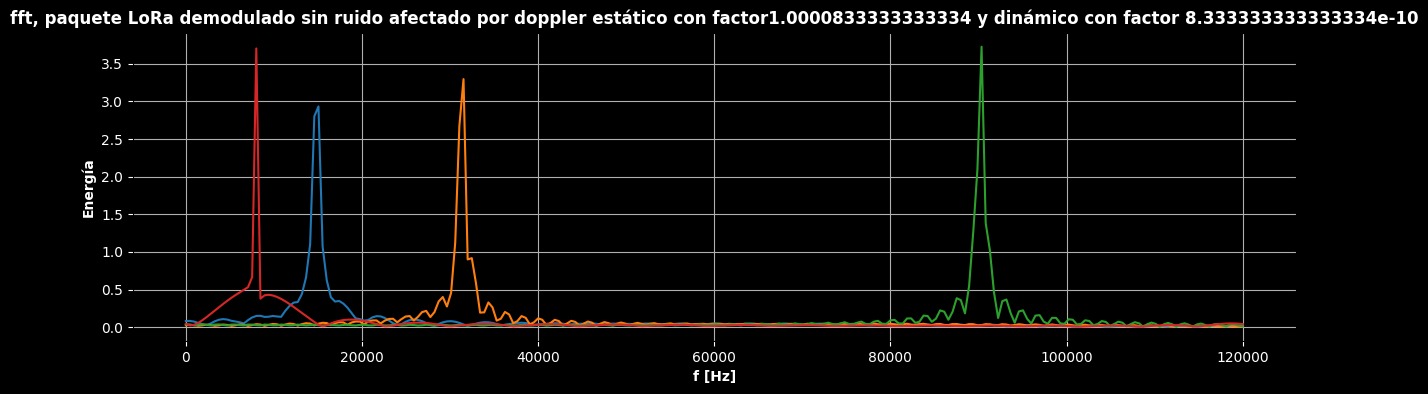

Los símbolos recibidos fueron: [32, 67, 192, 17]


In [14]:
data_length = 4  
datos = [30, 65, 190, 15]
preamble_size = 8
static_factor = (Bw+10)/Bw
dynamic_factor = 0.0001/Bw

print('El mensaje transmitido fue ' + str(datos))
Lora_packet, LoRa_pack_time, LoRa_pack_freq = build_lora_packet(datos, preamble_size)

doppler_signal, _ = doppler_simple(Lora_packet, static_factor, 0, _n_symbols=(data_length + preamble_size + 2))
packet_CPAs, rx_symbols = dem_packet_on_phase(doppler_signal)
plot_signal('fft, paquete LoRa demodulado sin ruido afectado por doppler estático con factor ' + str(static_factor), 'f [Hz]', 'Energía', np.linspace(0, Bw, len(packet_CPAs[0])), *packet_CPAs, _ticks=True)
print('Los símbolos recibidos fueron: ' + str([round(rx_symbols[i]) for i in range(len(rx_symbols))]))

doppler_signal, _ = doppler_simple(Lora_packet, 1, dynamic_factor, _n_symbols=(data_length + preamble_size + 2))
packet_CPAs, rx_symbols = dem_packet_on_phase(doppler_signal)
plot_signal('fft, paquete LoRa demodulado sin ruido afectado por doppler dinámico con factor ' + str(dynamic_factor), 'f [Hz]', 'Energía', np.linspace(0, Bw, len(packet_CPAs[0])), *packet_CPAs, _ticks=True)
print('Los símbolos recibidos fueron: ' + str([round(rx_symbols[i]) for i in range(len(rx_symbols))]))

doppler_signal, _ = doppler_simple(Lora_packet, static_factor, dynamic_factor, _n_symbols=(data_length + preamble_size + 2))
packet_CPAs, rx_symbols = dem_packet_on_phase(doppler_signal)
plot_signal('fft, paquete LoRa demodulado sin ruido afectado por doppler estático con factor' + str(static_factor) + ' y dinámico con factor ' +str(dynamic_factor), 'f [Hz]', 'Energía', np.linspace(0, Bw, len(packet_CPAs[0])), *packet_CPAs, _ticks=True)
print('Los símbolos recibidos fueron: ' + str([round(rx_symbols[i]) for i in range(len(rx_symbols))]))

Analisis:
 - El efecto estático a pesar de su nombre, al enviar un paquete produce un error que incrementa con cada símbolo, esto se debe a que el mismo error se acumula por cada símbolo consecutivo, por lo que conociendolo y corrigiendolo desde el inicio se lo puede mitigar para todos los simbolos.
- El efecto dinámico se acumula e incrementa para cada símbolo consecutivo.

NOTA: Para obtener la variación en efecto doppler primero veo si el siguiente valor máximo es el siguiente o el anterior (Asi se si la frecuencia esta creciendo o aumentando) y hago un promedio ponderado como:

$$(s_i  CPA(s_i) + S_{i+-1}  CPA(s_{i+-1}))/(CPA(s_i)+CPA(s_{i+-1}))$$

Esto va a dar una lectura flotante del símbolo recibido con lo que se puede obtener una variación más precisa.


### TODO: Aplicación LDR0 mode. Reduce data rate (N = 2^{SF-2}) Pero aumenta la resistencia al efecto doppler


### TODO: Monte carlo para medir el BER por Doppler con y sin ruido

### TODO: Corrección de Doppler dinámico por lazo cerrado

- Comparar el símbolo leído con el anterior.
- Si la diferencia es menor a un rango se asume que es el mismo símbolo afectado por doppler y se usa la diferencia para formular.
- Cuando se obtiene un down-chirp se sabe que se llegó al SDF, con lo que la fórmula se considera completa y se la usa para corregir doppler dinámico en los datos.
- Si la diferencia supera el rango se asume que nunca se estuvo en el preámbulo, y esto es ruido.

La teoría anterior considera la media 0 del ruido para asegurar que la fórmula será correcta, esto implíca que más símbolos en el preámbulo mejora la fidelidad de la lectura a cambio de un menor data rate. 

 

### Notas

- **Paquete LoRa**: 3 partes; preámbulo (x base up-chirps + 2 up-chirps indicando el ID de la red, ej. red pública), start frame delimiter (SFD, 2.25 down-chirps), datos (pueden incluir un header y un payload CRC (?), siempre contienen un payload)
- **Low Data Rate Optimization (LDRO)**: Es un modo que proporciona mayor estabilidad para grandes paquetes, a cambio de perder data rate. Se usa para DtS.
- El problema que observo en los gráficos parece deberse al cámbio brusco en frecuencia, esto produce un defasaje en la señal obtenida del producto del símbolo y el down-chirp, por eso se ve mal el gráfico en frecuencia. Aparentemente, una solución es sobre muestrear, lo que produce 2 picos (al igual que como hasta ahora) pero libres de distorsión con lo que sumando sus energías podemos recuperar el símbolo original sin la perdida por defasaje.




# Fuentes:

- https://www.epfl.ch/labs/tcl/wp-content/uploads/2020/02/Reverse_Eng_Report.pdf
- https://dl.acm.org/doi/10.1145/3546869#sec-6-1
- Paper: Lorenzo Vangelista. Frequency Shift Chirp Modulation: The LoRa Modulation. IEEE Signal Procesing Letters, Vol. 24, No. 12, 2017.
- Semtech SX1276/77/78/79 Datasheet, pagina 27.

